# Laboratorio 7 - Deep Reinforcement Learning
**Universidad del Valle de Guatemala**\
**Facultad de Ingeniería**\
**Departamento de Ciencias de la Computación**\
**Deep Learning**
---
Integrantes:
- Diego Leiva
- Pablo Orellana
- Maria Marta Ramirez
- Gabriel Garcia
- Luis Montenegro

# 1. Libraries Setup:

In [1]:
!pip install gymnasium numpy torch

You should consider upgrading via the 'c:\users\gegdg\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
import gymnasium as gym
import numpy as np

env = gym.make('CartPole-v1')


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize networks
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

online_net = QNetwork(state_size, action_size)
target_net = QNetwork(state_size, action_size)
target_net.load_state_dict(online_net.state_dict())


<All keys matched successfully>

In [4]:
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
learning_rate = 0.001
num_episodes = 500
update_target_every = 10  # Update target network every N episodes

optimizer = optim.Adam(online_net.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


In [5]:
def epsilon_greedy_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  # Random action
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_values = online_net(state)
        return torch.argmax(action_values).item()  # Best action


In [6]:
from collections import deque
import random

replay_memory = deque(maxlen=2000)

def add_experience(experience):
    replay_memory.append(experience)

def sample_experience(batch_size):
    return random.sample(replay_memory, batch_size)


In [7]:
for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = epsilon_greedy_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        add_experience((state, action, reward, next_state, done))

        state = next_state

        if len(replay_memory) > batch_size:
            experiences = sample_experience(batch_size)
            states, actions, rewards, next_states, dones = zip(*experiences)
            
            # Convert to tensors
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards = torch.FloatTensor(rewards).unsqueeze(1)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones).unsqueeze(1)

            # Q-learning update
            q_values = online_net(states).gather(1, actions)
            next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (gamma * next_q_values * (1 - dones))

            loss = criterion(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    # Update target network
    if episode % update_target_every == 0:
        target_net.load_state_dict(online_net.state_dict())

    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    print(f"Episode {episode}, Total Reward: {total_reward}")


Episode 0, Total Reward: 16.0
Episode 1, Total Reward: 22.0
Episode 2, Total Reward: 17.0
Episode 3, Total Reward: 23.0
Episode 4, Total Reward: 15.0
Episode 5, Total Reward: 12.0
Episode 6, Total Reward: 14.0
Episode 7, Total Reward: 22.0
Episode 8, Total Reward: 19.0


C:\Users\gegdg\AppData\Local\Temp\ipykernel_4348\2753767114.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.FloatTensor(states)


Episode 9, Total Reward: 42.0
Episode 10, Total Reward: 22.0
Episode 11, Total Reward: 14.0
Episode 12, Total Reward: 16.0
Episode 13, Total Reward: 45.0
Episode 14, Total Reward: 17.0
Episode 15, Total Reward: 23.0
Episode 16, Total Reward: 25.0
Episode 17, Total Reward: 51.0
Episode 18, Total Reward: 9.0
Episode 19, Total Reward: 18.0
Episode 20, Total Reward: 21.0
Episode 21, Total Reward: 25.0
Episode 22, Total Reward: 68.0
Episode 23, Total Reward: 13.0
Episode 24, Total Reward: 11.0
Episode 25, Total Reward: 20.0
Episode 26, Total Reward: 39.0
Episode 27, Total Reward: 14.0
Episode 28, Total Reward: 16.0
Episode 29, Total Reward: 19.0
Episode 30, Total Reward: 17.0
Episode 31, Total Reward: 13.0
Episode 32, Total Reward: 21.0
Episode 33, Total Reward: 19.0
Episode 34, Total Reward: 21.0
Episode 35, Total Reward: 21.0
Episode 36, Total Reward: 15.0
Episode 37, Total Reward: 16.0
Episode 38, Total Reward: 24.0
Episode 39, Total Reward: 45.0
Episode 40, Total Reward: 13.0
Episode 41

In [8]:
env.render()


c:\Users\gegdg\AppData\Local\Programs\Python\Python38\lib\site-packages\gymnasium\envs\classic_control\cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


In [9]:
env.close()


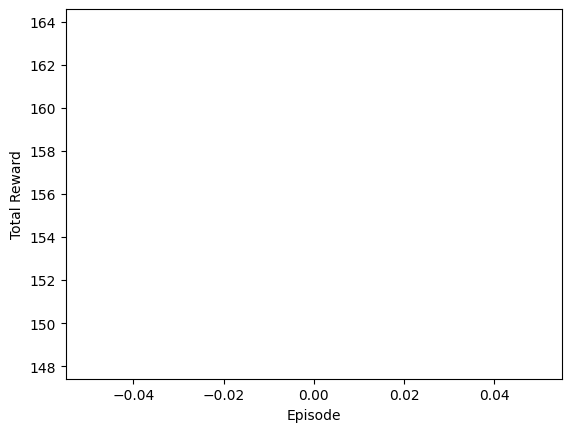

In [10]:
import matplotlib.pyplot as plt

rewards = []

# Inside the training loop, store total_reward for each episode
rewards.append(total_reward)

# After training
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


In [11]:
for _ in range(10):  # Run 10 evaluation episodes
    state, _ = env.reset()
    done = False
    while not done:
        action = epsilon_greedy_action(state, 0)  # No exploration
        state, reward, done, _, _ = env.step(action)
        total_reward += reward
    print(f"Total reward: {total_reward}")


Total reward: 320.0
Total reward: 486.0
Total reward: 644.0
Total reward: 810.0
Total reward: 974.0
Total reward: 1142.0
Total reward: 1304.0
Total reward: 1464.0
Total reward: 1632.0
Total reward: 1793.0
